<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

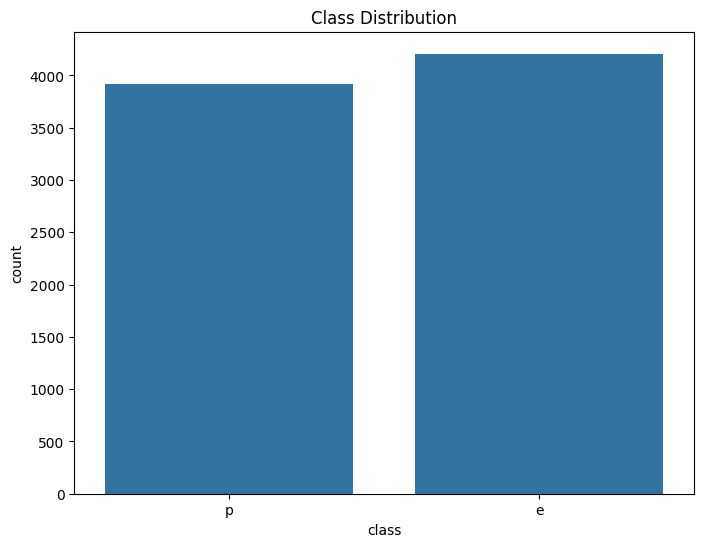

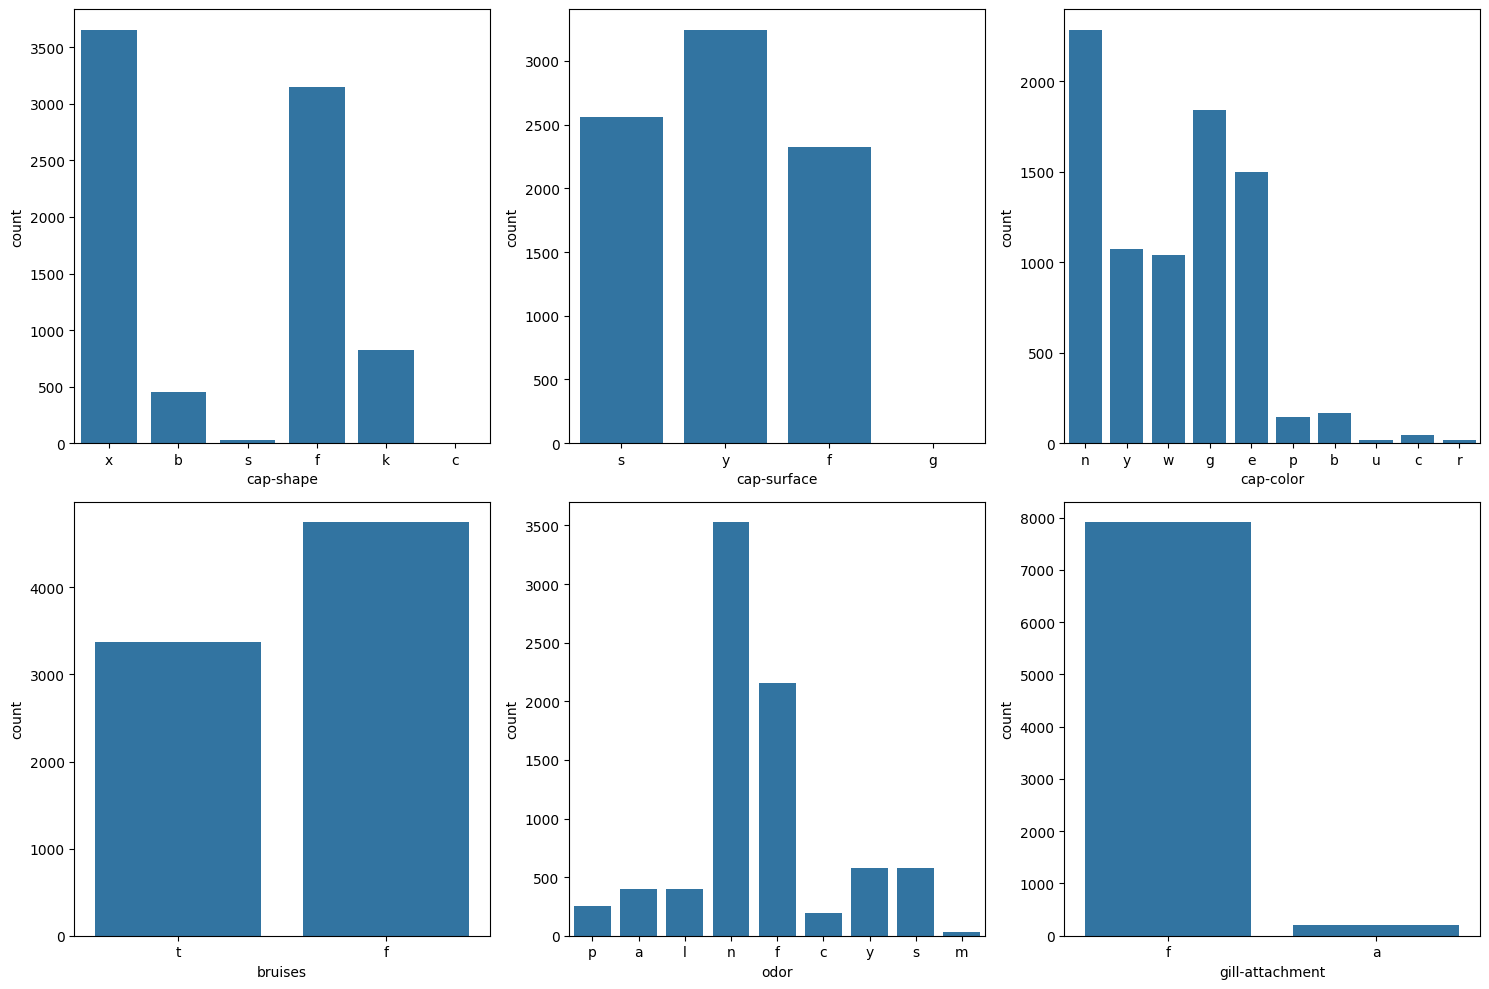

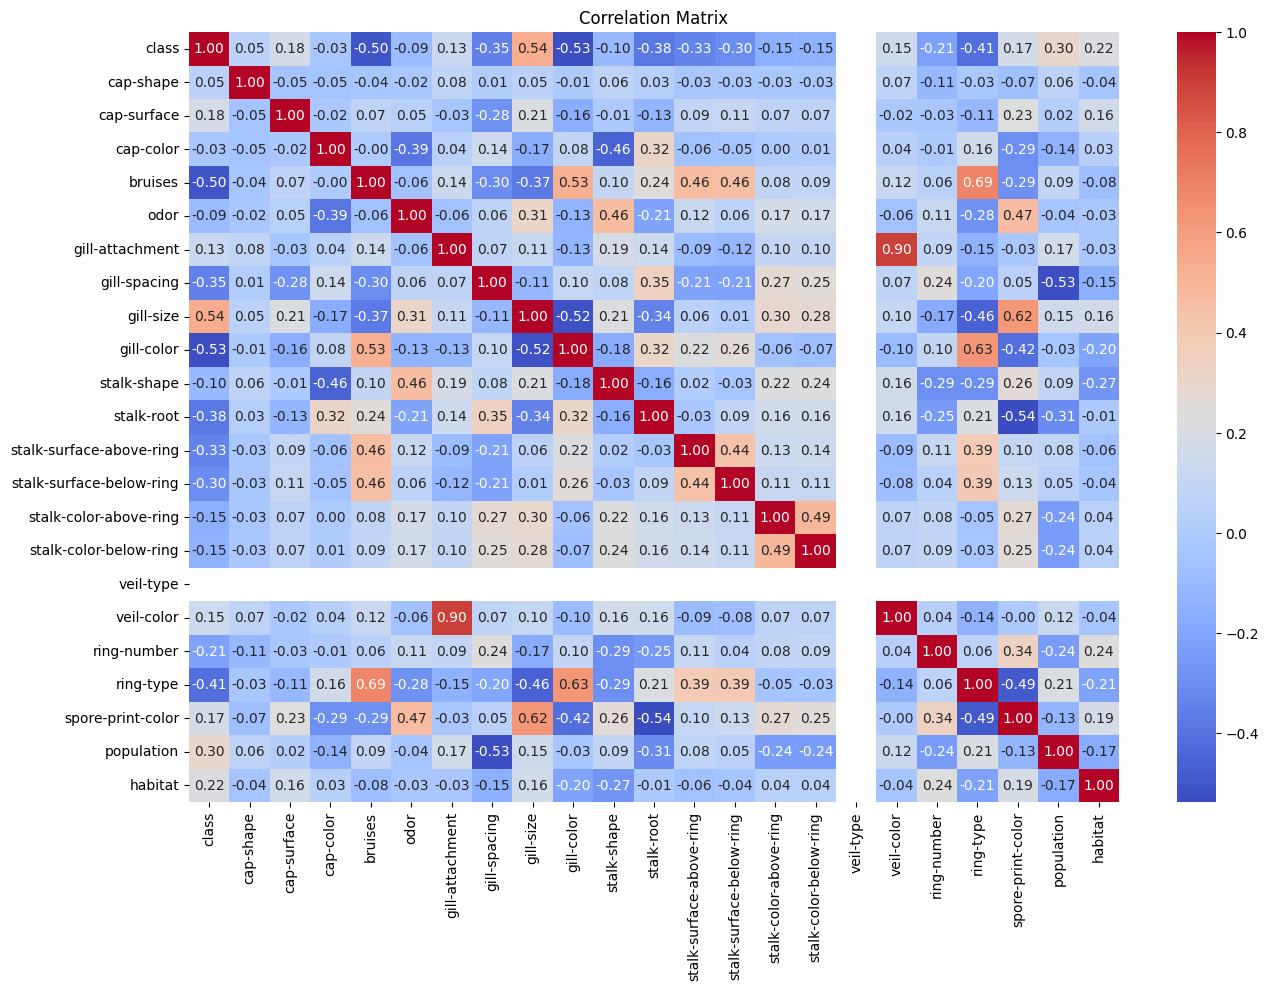

class: Skewness=0.07193224988597952, Kurtosis=-1.9948257514263408
cap-shape: Skewness=-0.24700637928120617, Kurtosis=-1.2423869516263428
cap-surface: Skewness=-0.5907497451740007, Kurtosis=-1.2769525649055313
cap-color: Skewness=0.7068342913350331, Kurtosis=-0.8364851781178197
bruises: Skewness=0.3426869271575418, Kurtosis=-1.8825656699553215
odor: Skewness=-0.08077478619378756, Kurtosis=-0.7768659647557654
gill-attachment: Skewness=-5.975972685654995, Kurtosis=33.71224953969458
gill-spacing: Skewness=1.83974847807238, Kurtosis=1.384674462569639
gill-size: Skewness=0.8256444104849662, Kurtosis=-1.3183113074349329
gill-color: Skewness=0.061398853411354266, Kurtosis=-1.286056382005263
stalk-shape: Skewness=-0.27129511258312494, Kurtosis=-1.9263989618885098
stalk-root: Skewness=0.9476773425430853, Kurtosis=0.0889672969601607
stalk-surface-above-ring: Skewness=-1.0985365054493224, Kurtosis=0.23952037027040562
stalk-surface-below-ring: Skewness=-0.7575632718648749, Kurtosis=0.22881765071125

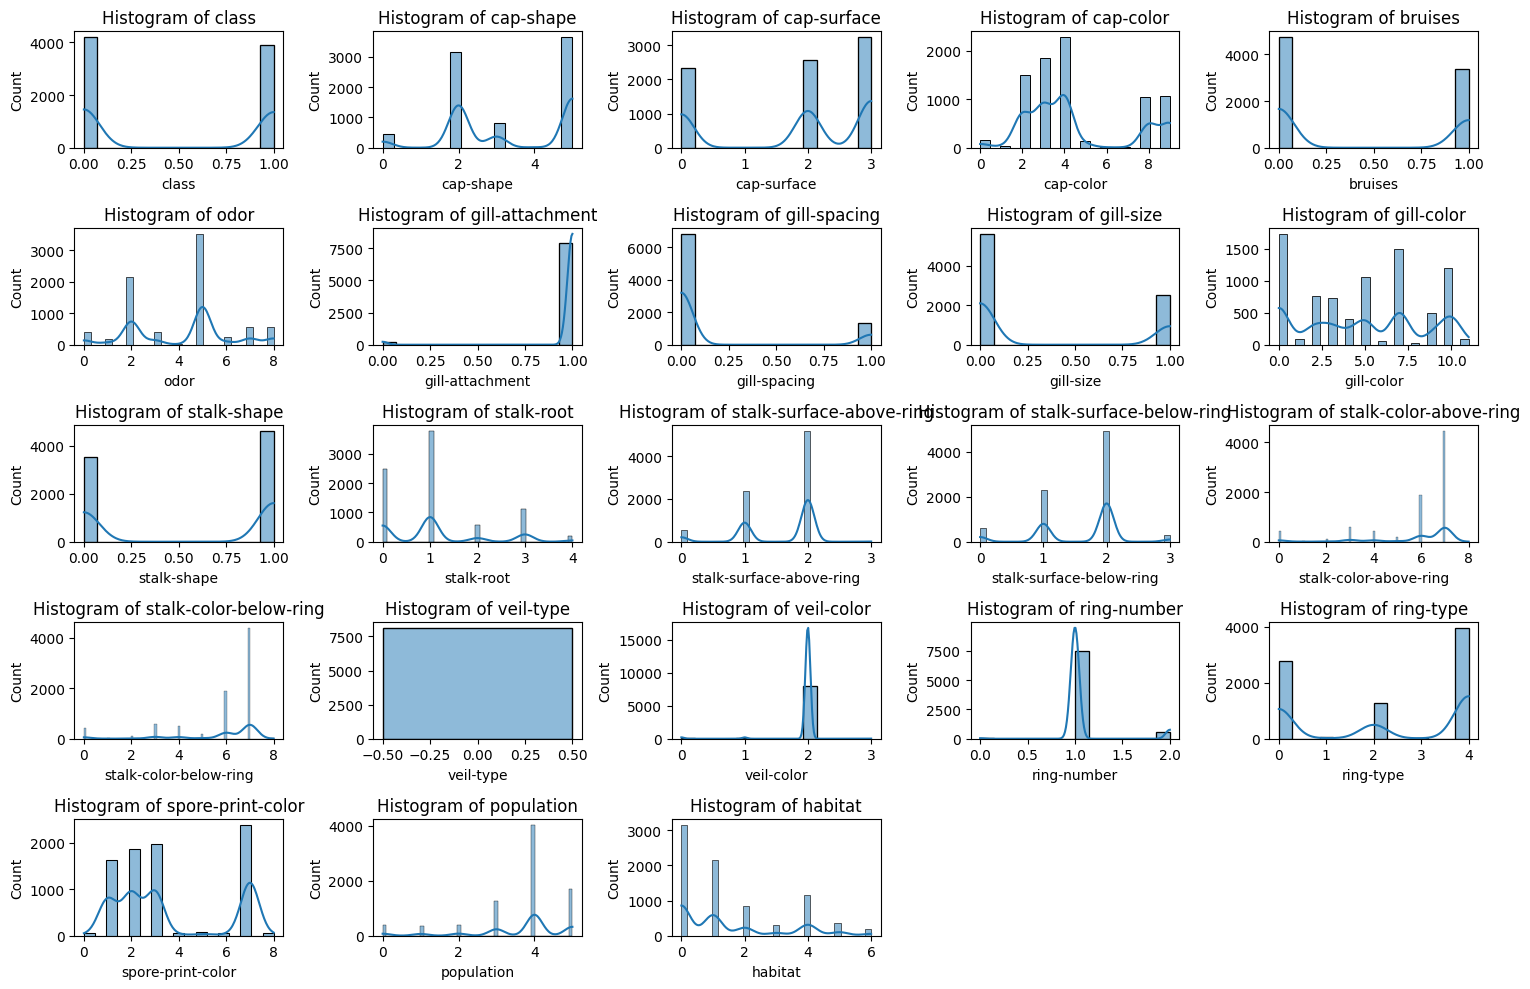

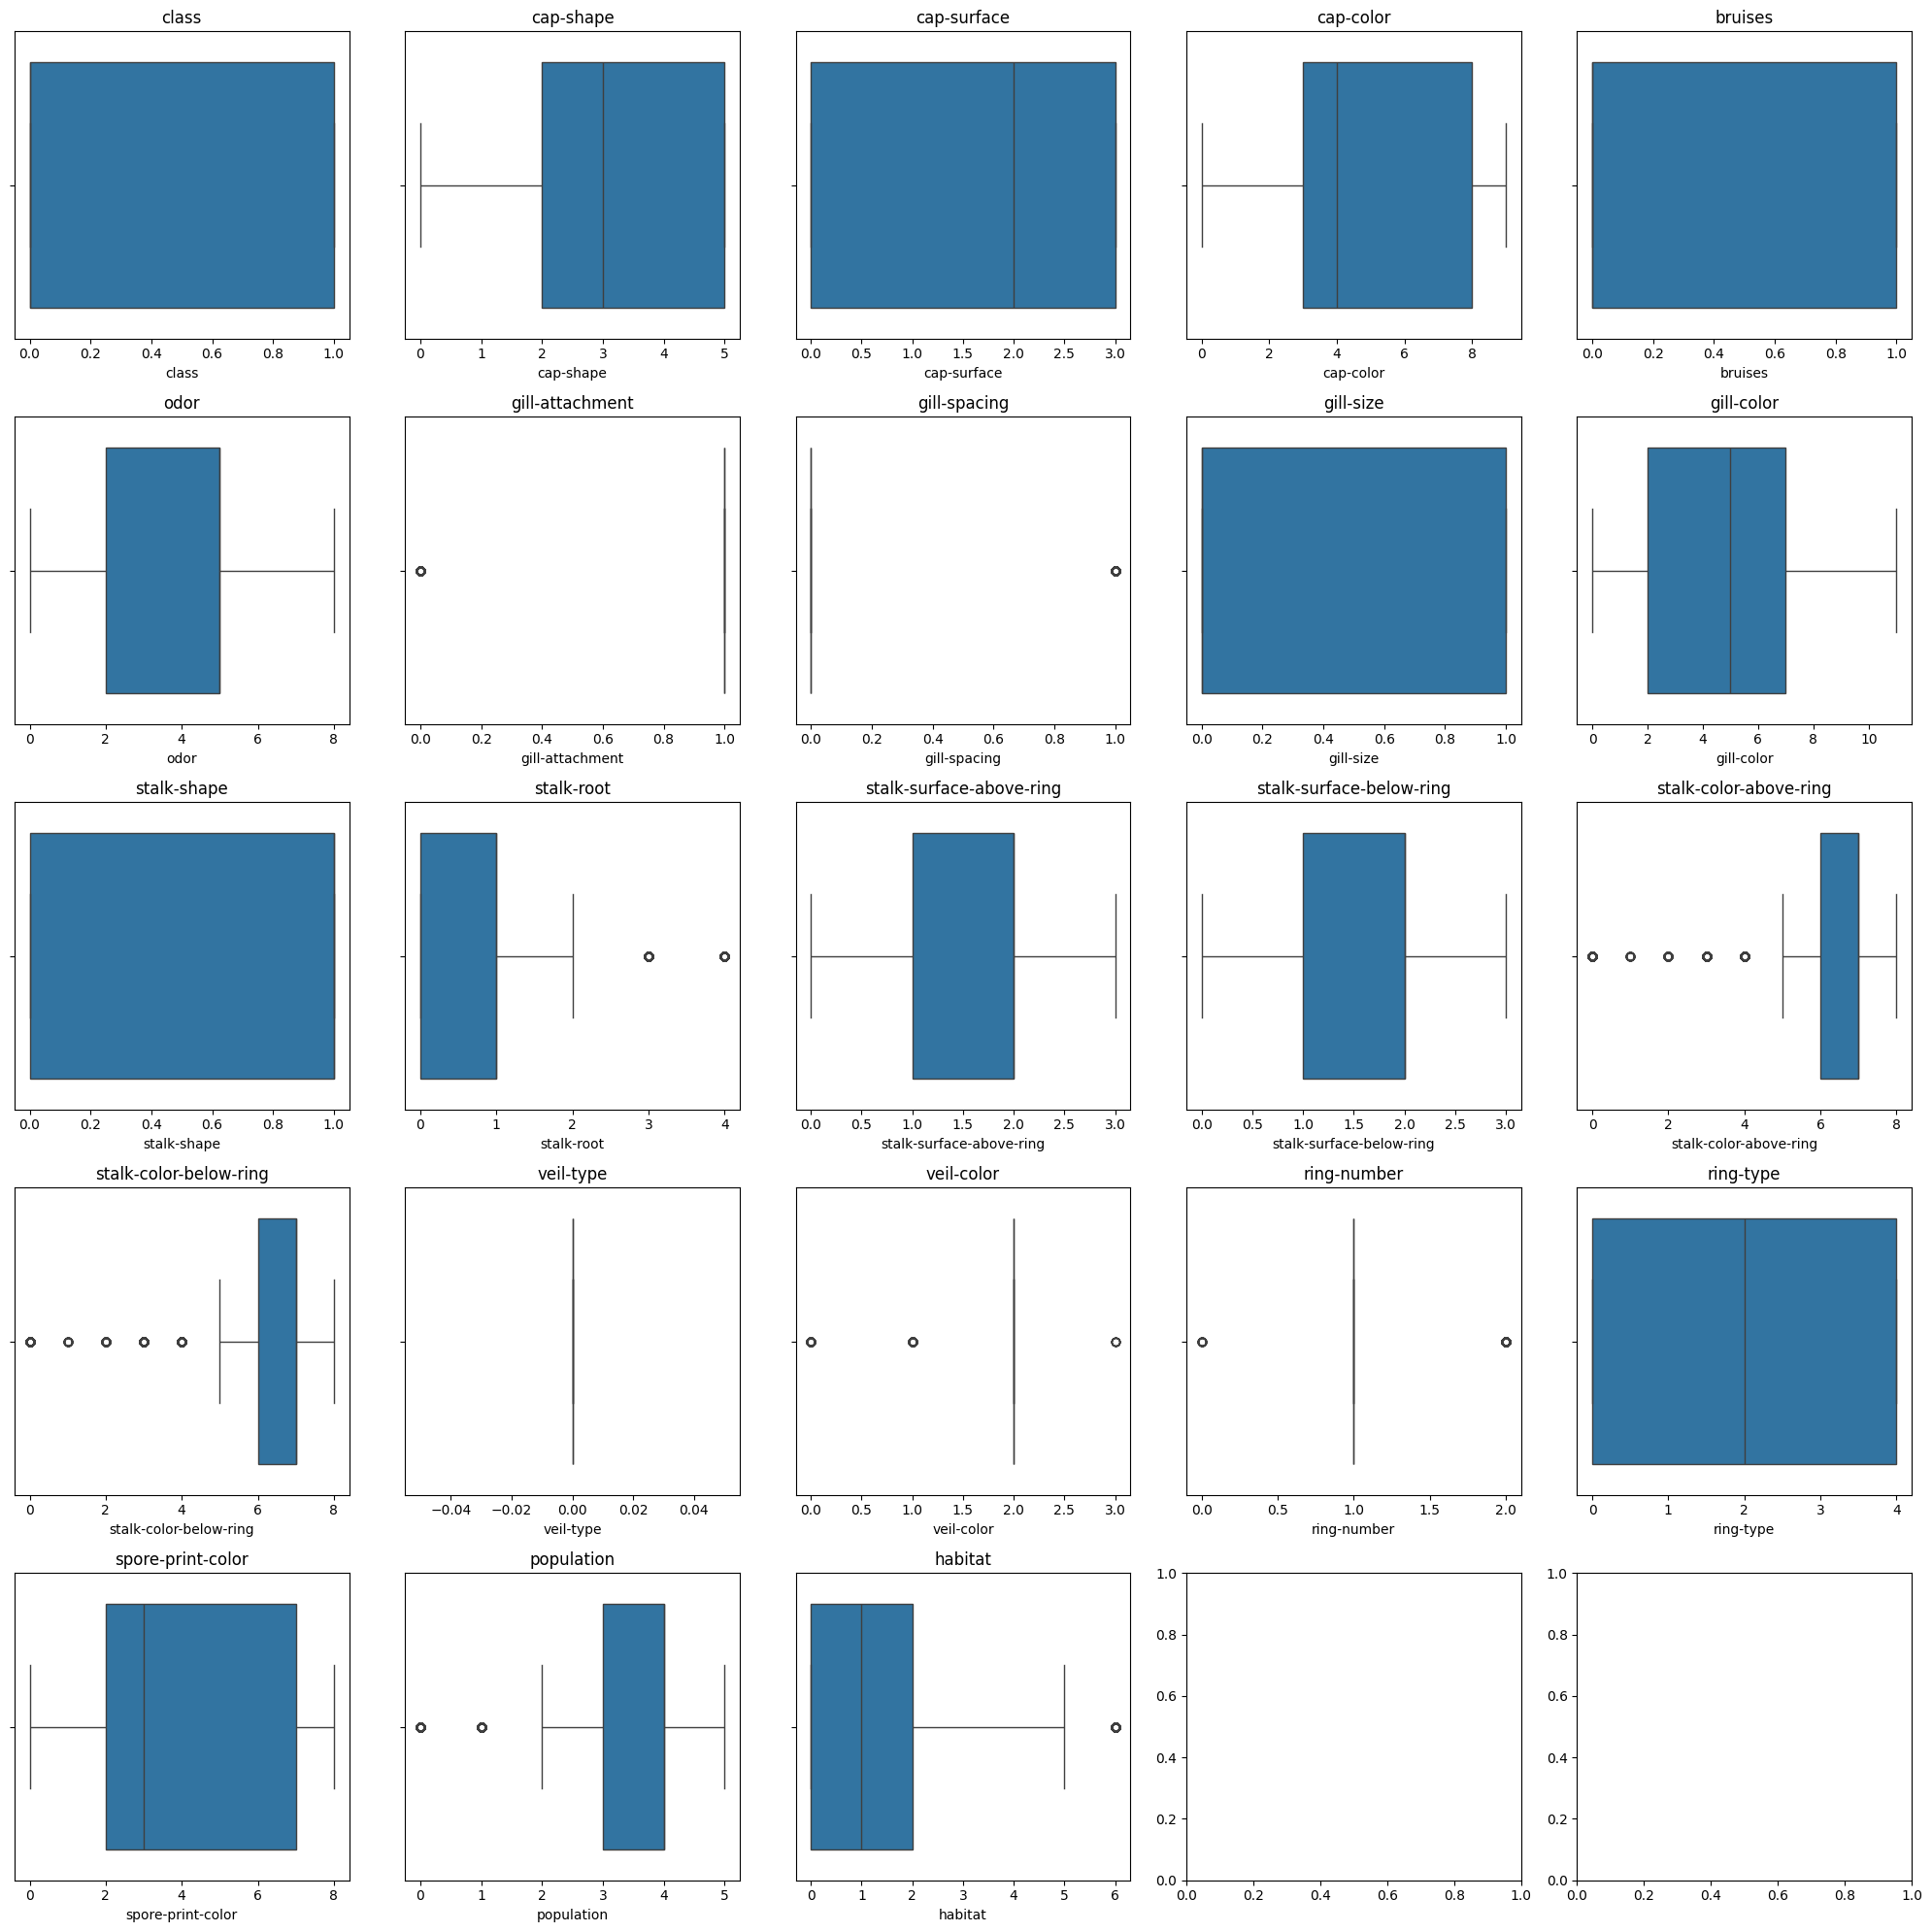

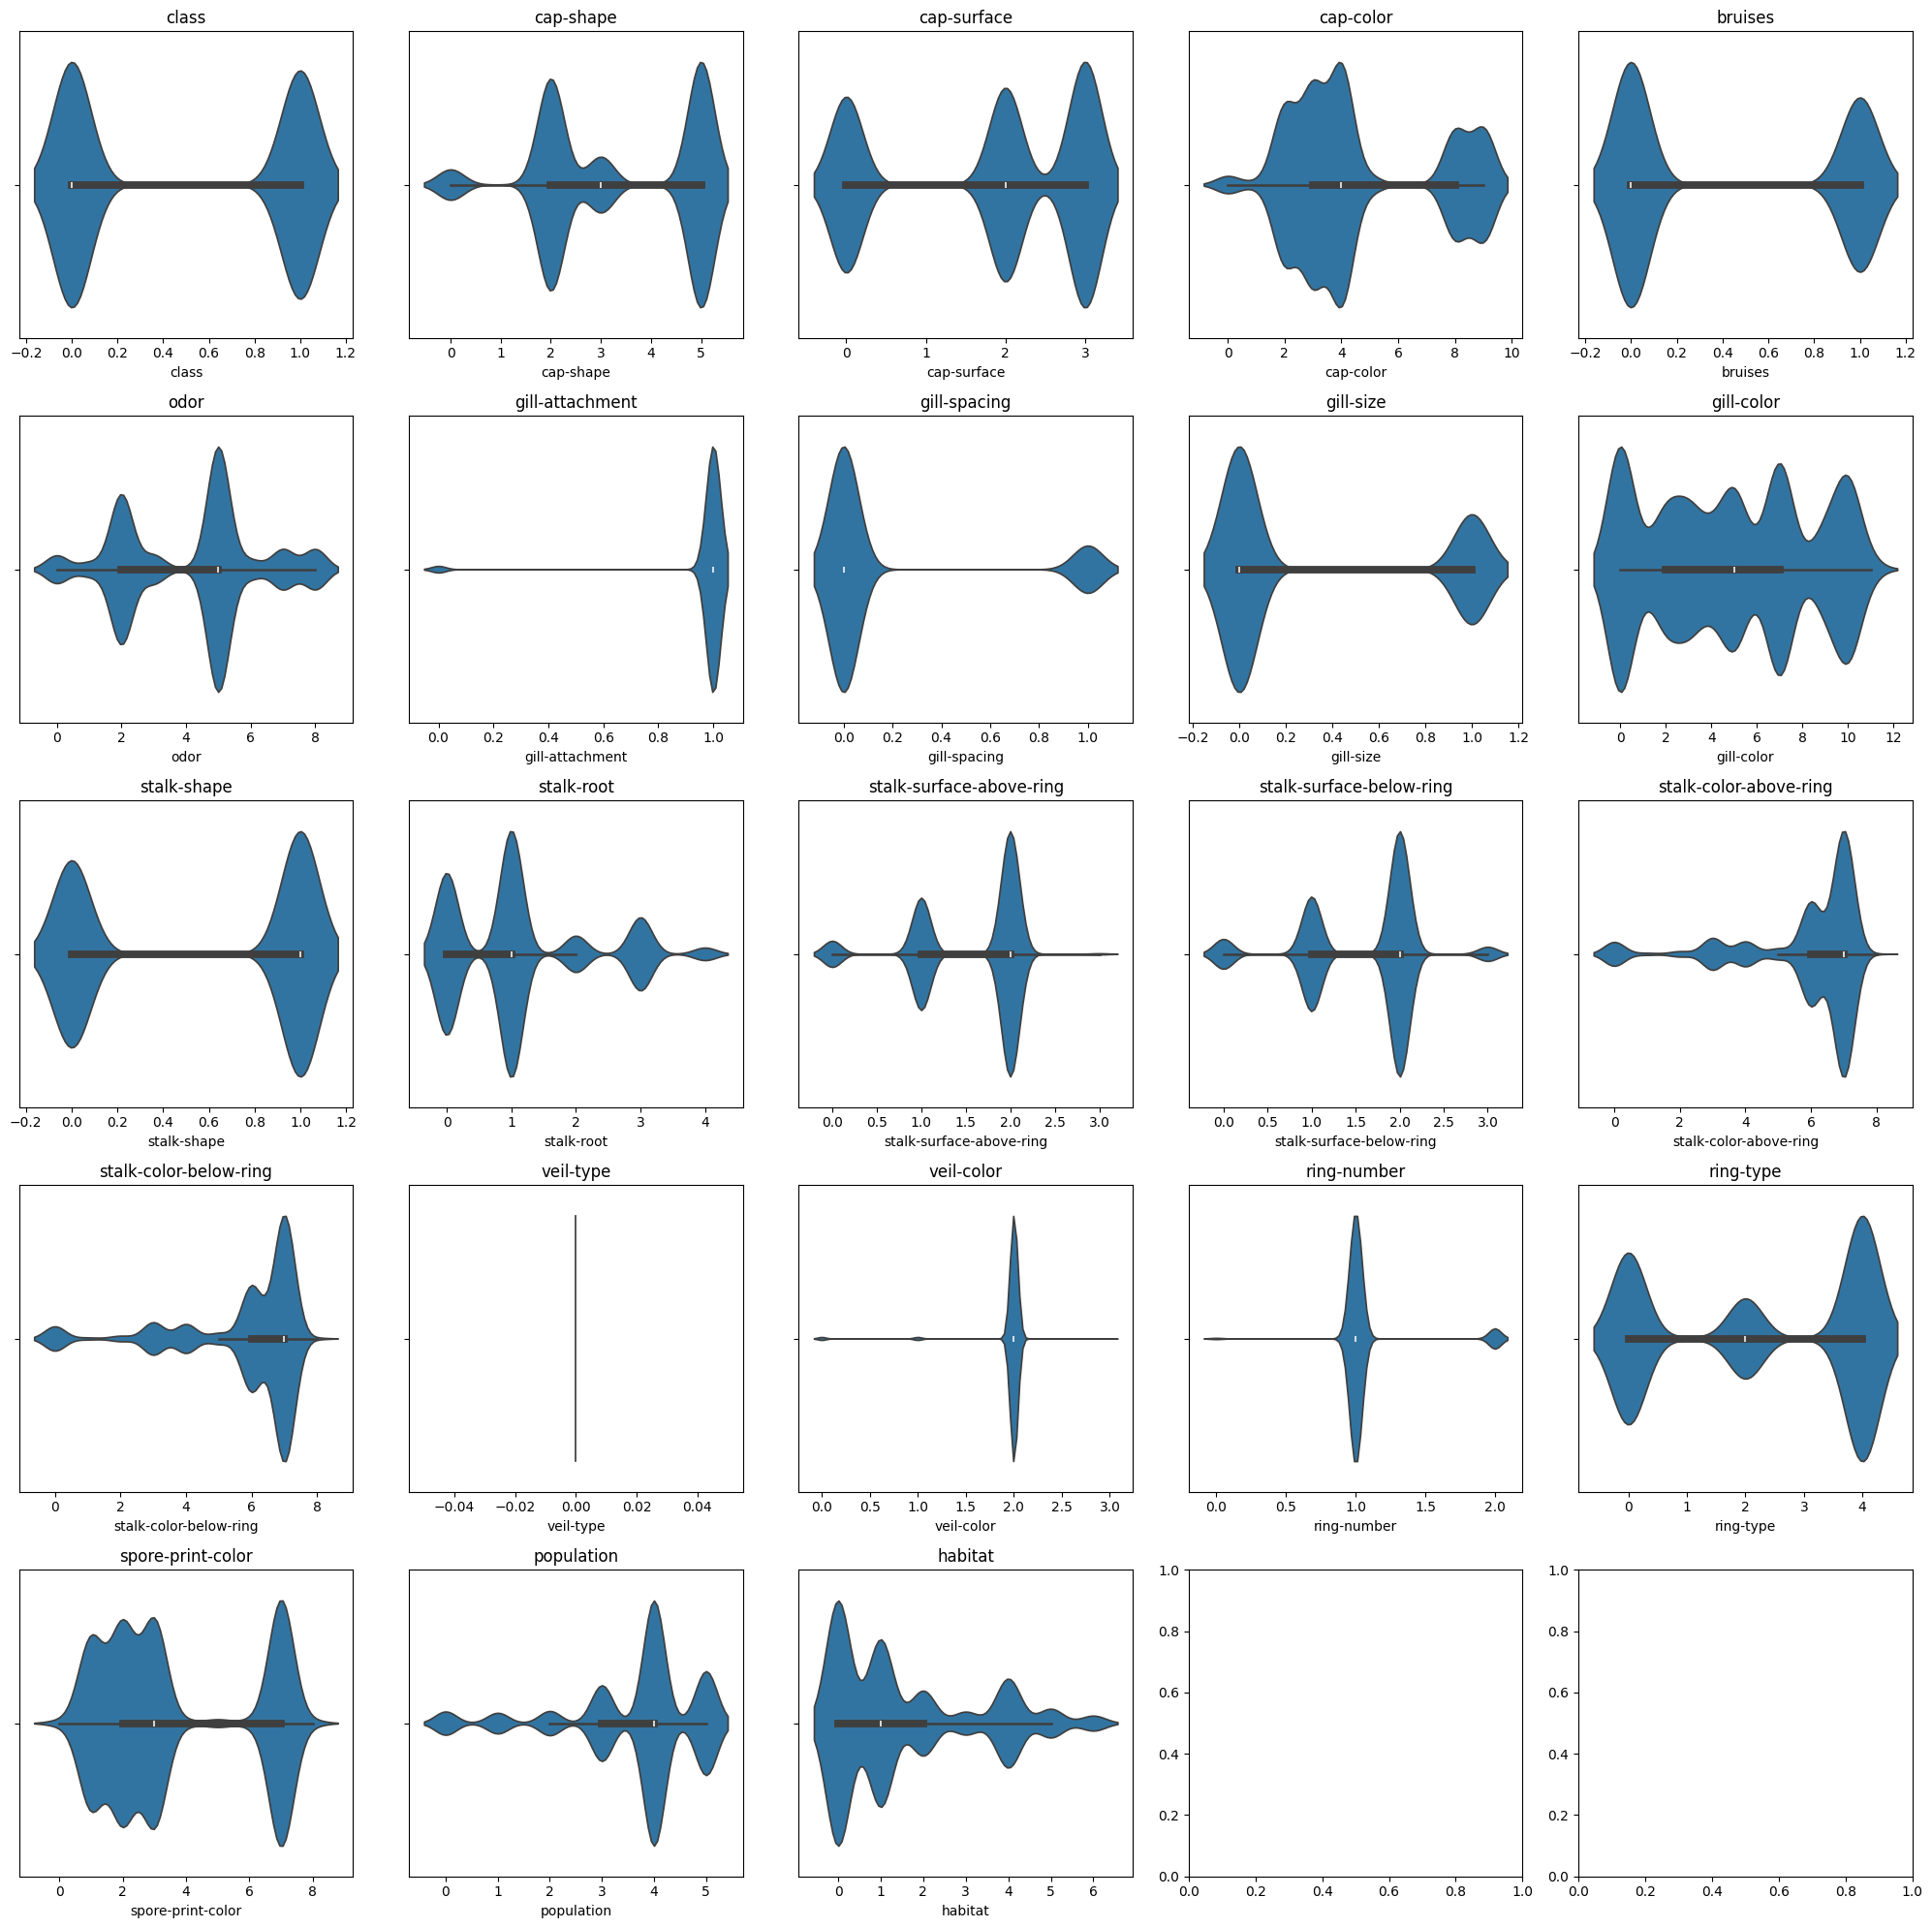

KeyboardInterrupt: 

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping

# Load the dataset
file_path = 'mushrooms.csv'
mushrooms_df = pd.read_csv(file_path)

# Display basic information and statistics of the dataset
print(mushrooms_df.info())
print(mushrooms_df.describe(include='all'))

# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=mushrooms_df)
plt.title('Class Distribution')
plt.show()

# Plot distribution of some features
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
sns.countplot(x='cap-shape', data=mushrooms_df, ax=axs[0, 0])
sns.countplot(x='cap-surface', data=mushrooms_df, ax=axs[0, 1])
sns.countplot(x='cap-color', data=mushrooms_df, ax=axs[0, 2])
sns.countplot(x='bruises', data=mushrooms_df, ax=axs[1, 0])
sns.countplot(x='odor', data=mushrooms_df, ax=axs[1, 1])
sns.countplot(x='gill-attachment', data=mushrooms_df, ax=axs[1, 2])
plt.tight_layout()
plt.show()

# Encode categorical variables
label_encoders = {}
for column in mushrooms_df.columns:
    le = LabelEncoder()
    mushrooms_df[column] = le.fit_transform(mushrooms_df[column])
    label_encoders[column] = le

# Display correlation matrix
corr_matrix = mushrooms_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Skewness and Kurtosis
for column in mushrooms_df.columns:
    skewness = skew(mushrooms_df[column])
    kurt = kurtosis(mushrooms_df[column])
    print(f'{column}: Skewness={skewness}, Kurtosis={kurt}')

# Histograms for detailed distribution analysis
plt.figure(figsize=(15, 10))
for i, column in enumerate(mushrooms_df.columns):
    plt.subplot(5, 5, i+1)
    sns.histplot(mushrooms_df[column], kde=True)
    plt.title(f'Histogram of {column}')
plt.tight_layout()
plt.show()

# Box plots to identify outliers
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
axs = axs.ravel()
for i, column in enumerate(mushrooms_df.columns):
    sns.boxplot(x=mushrooms_df[column], ax=axs[i])
    axs[i].set_title(column)
plt.tight_layout()
plt.show()

# Violin plots to see the distribution and outliers
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
axs = axs.ravel()
for i, column in enumerate(mushrooms_df.columns):
    sns.violinplot(x=mushrooms_df[column], ax=axs[i])
    axs[i].set_title(column)
plt.tight_layout()
plt.show()

# Pair plot for visualizing pairwise relationships
sns.pairplot(mushrooms_df, hue='class', palette='coolwarm')
plt.show()

# Separate features and target
X = mushrooms_df.drop('class', axis=1)
y = mushrooms_df['class']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Introduce noise into the features
def add_noise(data, noise_level=0.02):
    noise = np.random.binomial(1, noise_level, data.shape)
    noisy_data = (data + noise) % 2  # Ensure binary features stay binary
    return noisy_data

X_noisy = add_noise(X_scaled)

# Introduce noise into the labels
def add_label_noise(y, noise_level=0.02):
    n_samples = y.shape[0]
    n_noisy = int(n_samples * noise_level)
    noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)
    y_noisy = y.copy()
    y_noisy[noisy_indices] = 1 - y_noisy[noisy_indices]  # Flip the labels
    return y_noisy

y_noisy = add_label_noise(y)

# Split data into training and testing sets
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(X_noisy, y_noisy, test_size=0.2, random_state=42)

# Logistic Regression with L2 regularization
log_reg = LogisticRegression(max_iter=1000, C=0.01)
log_reg.fit(X_train_noisy, y_train_noisy)
log_reg_predictions = log_reg.predict(X_test_noisy)
log_reg_accuracy = accuracy_score(y_test_noisy, log_reg_predictions)
print("Logistic Regression Accuracy:", log_reg_accuracy)
print(classification_report(y_test_noisy, log_reg_predictions))

# SVM with enhanced hyperparameter tuning and regularization
svm = SVC()
param_grid = {
    'C': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}
grid_search_svm = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train_noisy, y_train_noisy)
svm_best_model = grid_search_svm.best_estimator_
svm_predictions = svm_best_model.predict(X_test_noisy)
svm_accuracy = accuracy_score(y_test_noisy, svm_predictions)
print("SVM Best Parameters:", grid_search_svm.best_params_)
print("SVM Accuracy with Noisy Data:", svm_accuracy)
print(classification_report(y_test_noisy, svm_predictions))

# AdaBoost with cross-validation
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.05)
ada.fit(X_train_noisy, y_train_noisy)
ada_predictions = ada.predict(X_test_noisy)
ada_accuracy = accuracy_score(y_test_noisy, ada_predictions)
print("AdaBoost Accuracy", ada_accuracy)
print(classification_report(y_test_noisy, ada_predictions))

ada_scores = cross_val_score(AdaBoostClassifier(), X_noisy, y_noisy, cv=5, n_jobs=-1)
print(f"AdaBoost Cross-Validation Scores: {ada_scores}")
print(f"Mean CV Accuracy for AdaBoost: {ada_scores.mean()}")

# Stacking Ensemble
base_models = [
    ('log_reg', LogisticRegression(max_iter=1000, C=0.01)),
    ('svm', svm_best_model),
    ('ada', AdaBoostClassifier(n_estimators=100, learning_rate=0.05))
]
stacking = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(C=0.01))
stacking.fit(X_train_noisy, y_train_noisy)
stacking_predictions = stacking.predict(X_test_noisy)
stacking_accuracy = accuracy_score(y_test_noisy, stacking_predictions)
print("Stacking Ensemble Accuracy:", stacking_accuracy)
print(classification_report(y_test_noisy, stacking_predictions))

# FCNN (Fully Connected Neural Network) with Dropout and Early Stopping
fcnn_model = Sequential()
fcnn_model.add(Input(shape=(X_train_noisy.shape[1],)))
fcnn_model.add(Dense(64, activation='relu'))
fcnn_model.add(Dropout(0.5))
fcnn_model.add(Dense(32, activation='relu'))
fcnn_model.add(Dense(1, activation='sigmoid'))

fcnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = fcnn_model.fit(X_train_noisy, y_train_noisy, epochs=50, batch_size=32, validation_data=(X_test_noisy, y_test_noisy), callbacks=[early_stopping])

loss, fcnn_accuracy = fcnn_model.evaluate(X_test_noisy, y_test_noisy)
print("FCNN Accuracy:", fcnn_accuracy)

# Save the models
joblib.dump(log_reg, 'log_reg_model.pkl')
joblib.dump(svm_best_model, 'svm_model.pkl')
joblib.dump(ada, 'ada_model.pkl')
joblib.dump(stacking, 'stacking_model.pkl')
fcnn_model.save('fcnn_model.keras')

# Plotting the accuracies of different models
accuracies = {
    'Logistic Regression': log_reg_accuracy,
    'SVM': svm_accuracy,
    'AdaBoost': ada_accuracy,
    'Stacking Classifier': stacking_accuracy,
    'FCNN': fcnn_accuracy
}

plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()

# Plotting the loss and accuracy over epochs for the FCNN
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()
